In [ ]:
import os
import cv2
import monai
import numpy as np
from numpy import ndarray
from PIL import Image
from tqdm import tqdm
from statistics import mean
from typing import Dict, List, Tuple
from matplotlib import pyplot as plt

import torch
from torch import device as tdevice
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.functional import threshold, normalize

from transformers import SamProcessor
from transformers import SamModel
from typing import List, Dict

from finetune import resume, calc_metrics, postprocess_masks, \
    get_point_prompt_bymask, dilate_mask, \
    PSVDataset, SAMDataset

os.environ["CUDA_VISIBLE_DEVICES"] = ""
color_list: List = [
    # Yellow
    np.array([1, 1, 0, 0.3]),
    # Blue
    np.array([0, 0, 1, 0.3]),
    # Purple
    np.array([0.5, 0, 0.5, 0.3]),
    # Red
    np.array([1, 0, 0, 0.3]),
    # Green
    np.array([0, 1, 0, 0.3]),
    # Orange
    np.array([1, 0.5, 0, 0.3]),
    # Pink
    np.array([1, 0, 1, 0.3]),
    # Brown
    np.array([0.5, 0.25, 0, 0.3]),
    # Gray
    np.array([0.5, 0.5, 0.5, 0.3]),
    # Black
    np.array([0, 0, 0, 0.3]),
    # Teal
    np.array([0, 0.5, 0.5, 0.3]),
    # Navy
    np.array([0, 0, 0.5, 0.3])
]


def show_mask(mask, ax, mask_color=None, random_color=False):
    if mask_color is not None:
        color = mask_color
    else:
        if random_color:
            color = np.concatenate(
                [np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])

    if issubclass(type(mask), torch.Tensor):
        mask = mask.cpu().numpy()
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


In [ ]:
device: tdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
iou: List[float] = []
dsc: List[float] = []

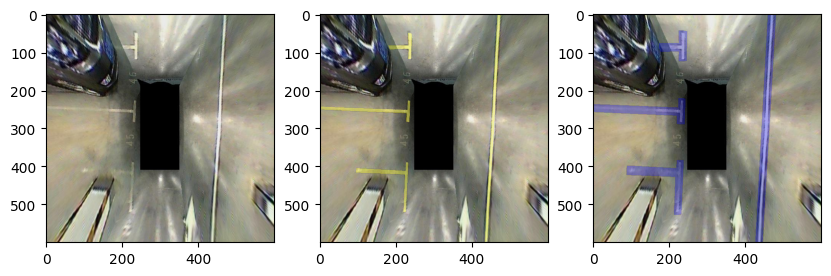

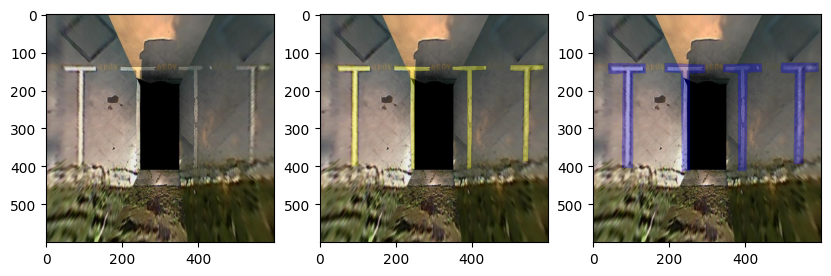

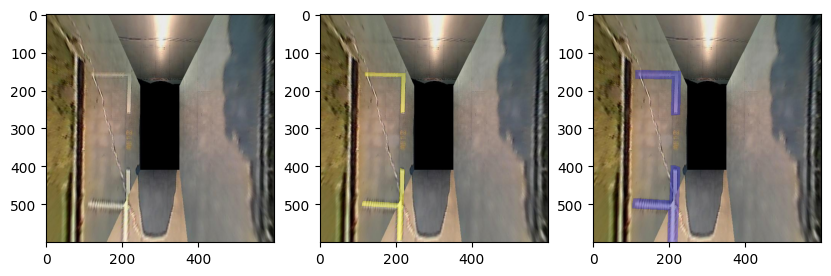

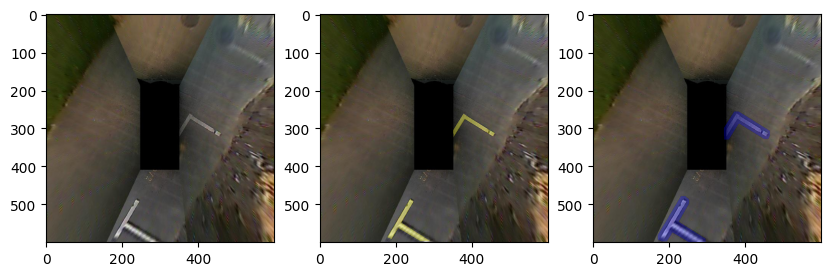

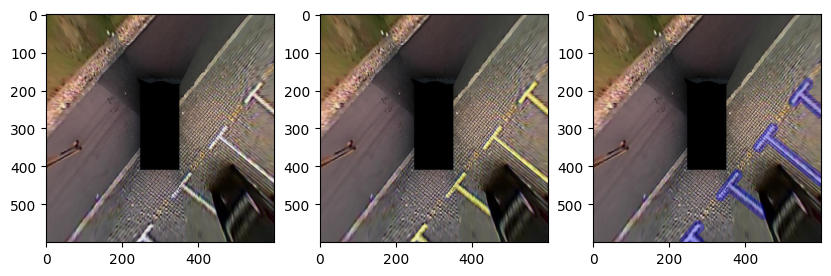

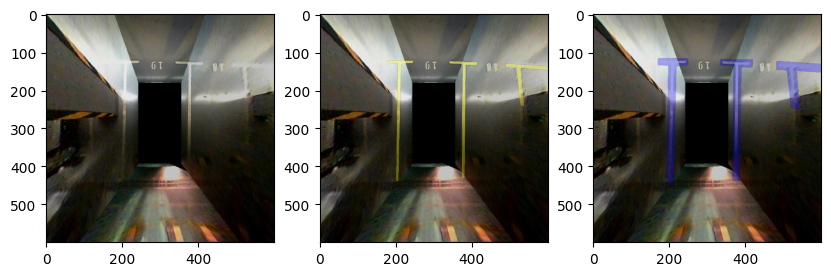

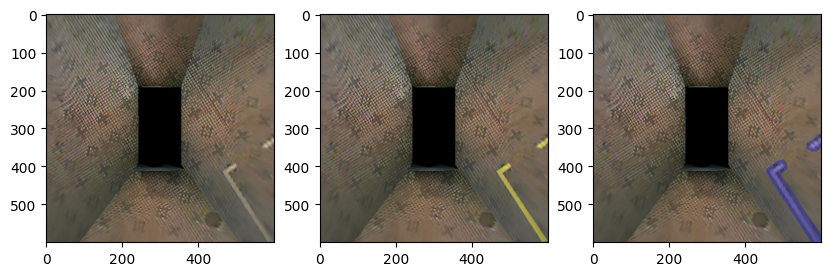

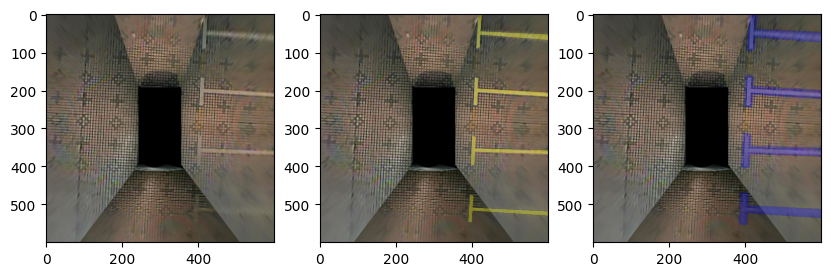

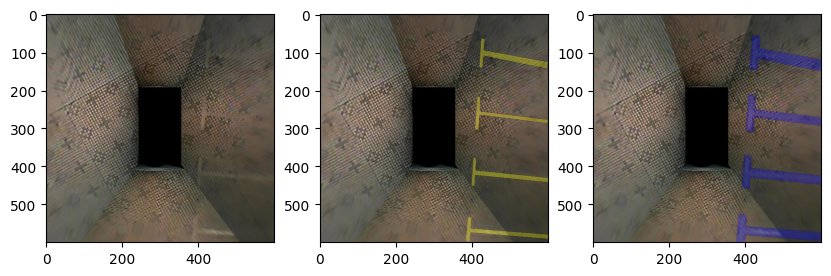

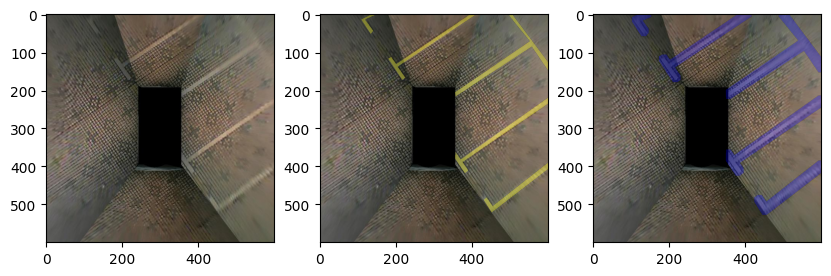

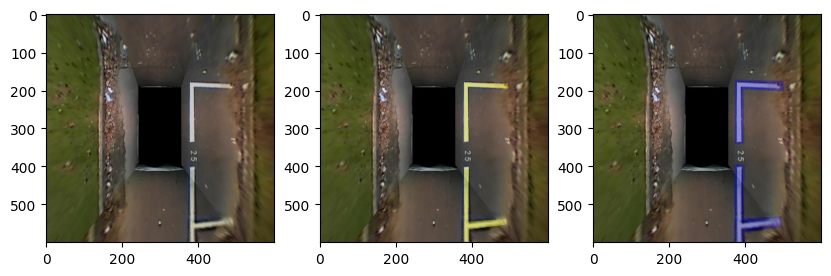

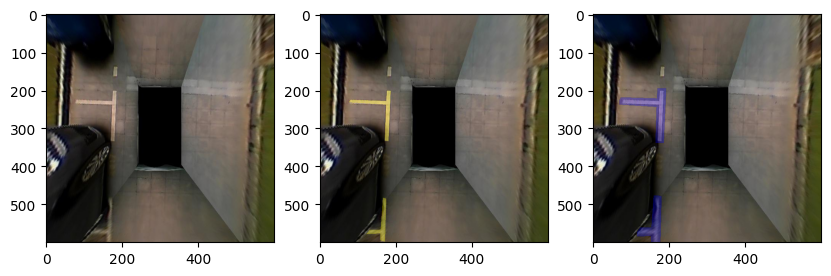

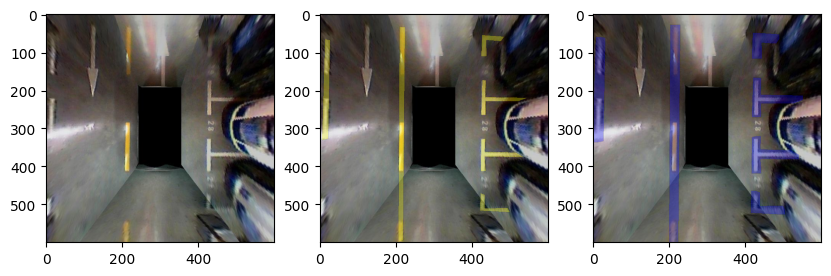

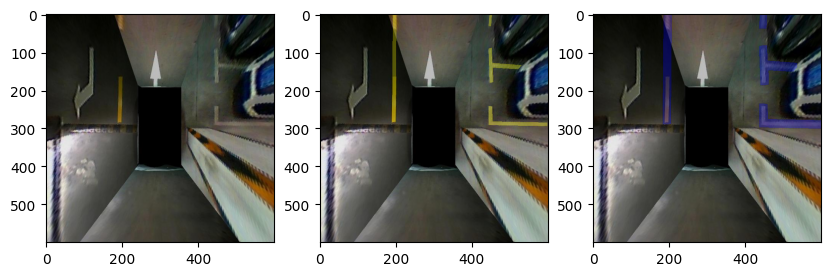

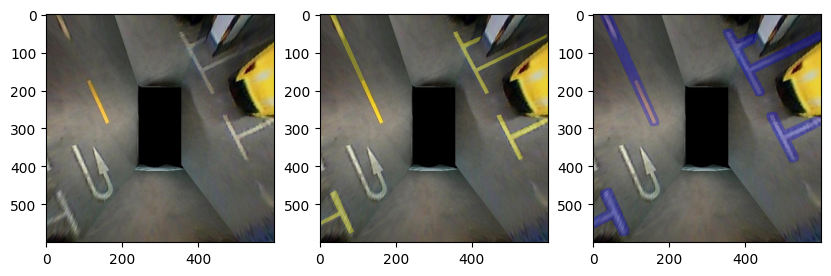

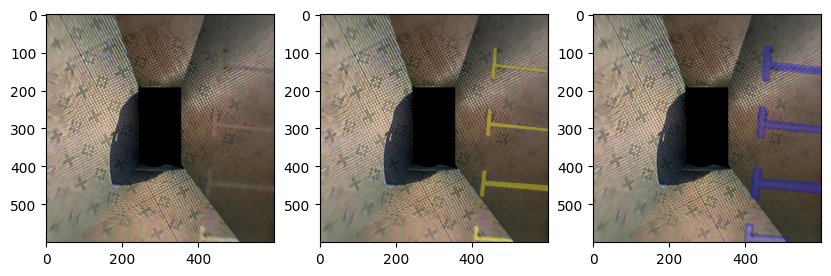

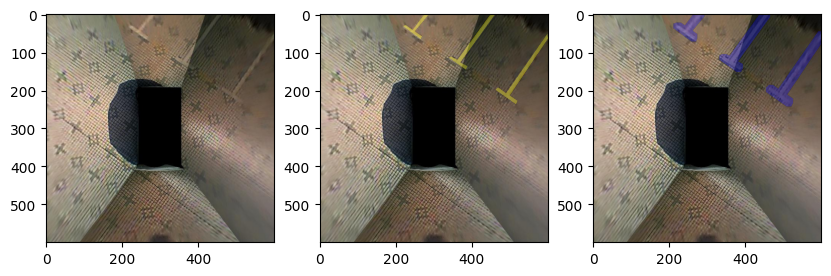

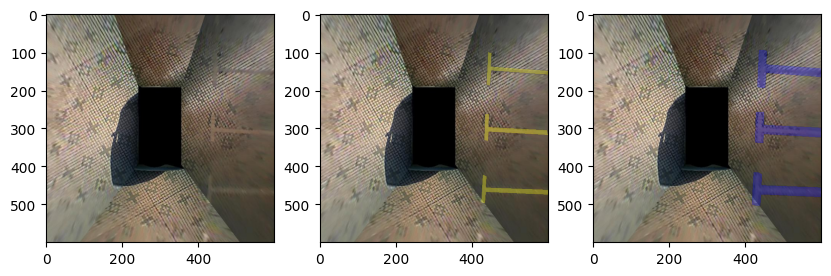

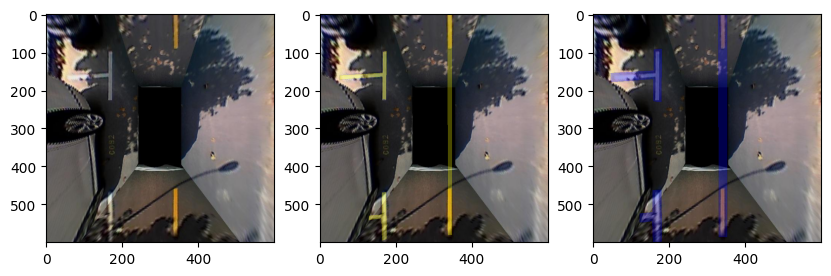

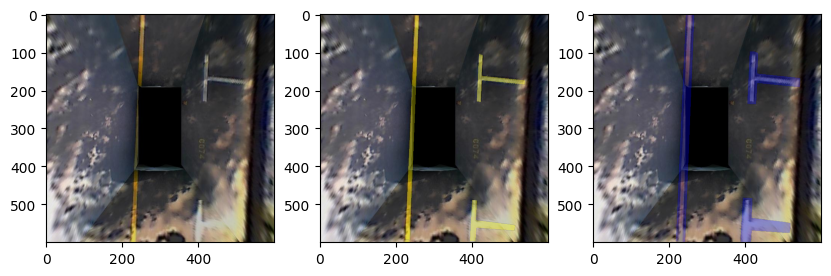

In [4]:
i = 0
i_max = 20
train_dataset = PSVDataset(split='train', ds_size=1.)
for idx in range(i_max):
    item: Dict[str, ndarray] = train_dataset[idx]
    image: ndarray = item['image']
    gt_mask: ndarray = item['label']
    noise_mask: ndarray = dilate_mask(gt_mask, 5, 3)

    fig, axes = plt.subplots(1, 3, figsize=(10, 30))
    axes[0].imshow(image)

    axes[1].imshow(image)
    show_mask(gt_mask, axes[1], mask_color=color_list[0])

    axes[2].imshow(image)
    show_mask(noise_mask, axes[2], mask_color=color_list[1])
    plt.show()


## Plot Accuracy Curve

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
accu = '21.73 41.20 68.45 72.60 74.59 75.96 76.94 77.66 78.28 78.59 79.10 79.45 79.75 79.85 80.10 80.32 80.53 80.74 80.76 80.77 80.81'
patn = r'(\d+\.\d+)'
accu = re.findall(patn, accu)
accu = [float(i) for i in accu]
epochs = np.arange(0, 105, 5)

plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(epochs, accu, color="black")
for idx, y in enumerate(accu):
    plt.plot(epochs[:idx + 1], [y] * (idx + 1),
                "--", lw=1, color="green", alpha=0.7)
for idx, epoch in enumerate(epochs):
    plt.plot([epoch] * (idx + 1), accu[:idx + 1],
                "--", lw=1, color="red", alpha=0.7)
for idx, epoch in enumerate(epochs):
    plt.scatter(epoch, accu[idx], color="orange", s=50)
plt.ylim(min(accu), 82)
plt.xlim(0, 105)
plt.xticks(fontsize=14)
plt.yticks([min(accu)] + list(range(30, 90, 10)), fontsize=14)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('mIoU', fontsize=16)
# plt.axis('off')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.show()

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
accu = '41.20 68.45 72.60 74.59 75.96 76.94 77.66 78.28 78.59 79.10 79.45 79.75 79.85 80.10 80.32 80.53 80.74 80.76 80.77 80.81'
patn = r'(\d+\.\d+)'
accu = re.findall(patn, accu)
accu = [float(i) for i in accu]
accu = list(np.array(accu[1:]) - np.array(accu[: -1])) + [0]
print(accu)
epochs = np.arange(0, 100, 5)

plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(epochs, accu, color="black")
for idx, y in enumerate(accu):
    plt.plot(epochs[:idx + 1], [y] * (idx + 1),
                "--", lw=1, color="green", alpha=0.7)
for idx, epoch in enumerate(epochs):
    plt.plot([epoch, epoch], [0, accu[idx]],
                "--", lw=1, color="red", alpha=0.7)
for idx, epoch in enumerate(epochs):
    plt.scatter(epoch, accu[idx], color="orange", s=50)
plt.ylim(min(accu), 30)
plt.xlim(0, 100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('diff-mIoU', fontsize=16)
# plt.axis('off')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.show()